In [38]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import tensorflow as tf

In [39]:
train_folder_path = r'C:./set1/train'
test_folder_path = r'C:./set2/test'

In [40]:
os.path.exists(train_folder_path)

True

In [41]:
class_names = next(os.walk(train_folder_path))[1]
class_names = class_names[0:]
class_names

['belly_pain', 'discomfort', 'hungry', 'tired']

In [42]:
audio_path = [os.path.join(train_folder_path, name) for name in class_names]
audio_path

['C:./set1/train\\belly_pain',
 'C:./set1/train\\discomfort',
 'C:./set1/train\\hungry',
 'C:./set1/train\\tired']

In [43]:
bpain_audio = glob.glob(os.path.join(audio_path[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_path[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_path[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_path[3], '*.wav'))

In [44]:
audio_path_byclass = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

## Load Audio

In [45]:
# Replace 'your_audio_file.mp3' with the path to your audio file
load_audio = {}
for name, pathlst in audio_path_byclass.items():
    loaded = []
    for path in pathlst:
        audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.2)
        loaded.append(audio)
    load_audio[name] = loaded

In [46]:
mfcc_audio = {}
for name, pathlst in audio_path_byclass.items():
    mfccs = []
    for path in pathlst:
        audio, sr = librosa.load(path, sr=16000, mono=True, duration=5.0)
        mfcc = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=10)
        mfccs.append(mfcc)
    mfcc_audio[name] = mfccs

In [47]:
import collections

shape = {}

for class_name, lst in mfcc_audio.items():
    for arr in lst:
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape[f'{class_name} mfcc shape counts'] = shapes_count

## Load Model

In [48]:
# Load the model.
import tensorflow_hub as hub
model = hub.load('https://tfhub.dev/google/yamnet/1')

In [49]:
# Run the model, check the output.
feature = {}
for name, arr in load_audio.items():
    # Initialize dictionaries for each class if not already existing
    if name not in feature:
        feature[name] = {'scores': [], 'embeddings': [], 'spectrograms': []}
    
    for wav in arr:
        scores, embeddings, spectrogram = model(wav)
        
        # Append the results to the respective lists in the dictionary
        feature[name]['scores'].append(np.array(scores))
        feature[name]['embeddings'].append(np.array(embeddings))
        feature[name]['spectrograms'].append(np.array(spectrogram))

In [50]:
shape_feat = {}

for class_name in feature.keys():
    for cat, lst in feature[class_name].items():
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape_feat[f'{class_name} {cat} shape counts'] = shapes_count

In [51]:
shape_feat

{'bpain scores shape counts': Counter({(10, 521): 69}),
 'bpain embeddings shape counts': Counter({(10, 1024): 69}),
 'bpain spectrograms shape counts': Counter({(528, 64): 69}),
 'discomf scores shape counts': Counter({(10, 521): 94}),
 'discomf embeddings shape counts': Counter({(10, 1024): 94}),
 'discomf spectrograms shape counts': Counter({(528, 64): 94}),
 'hungry scores shape counts': Counter({(10, 521): 100}),
 'hungry embeddings shape counts': Counter({(10, 1024): 100}),
 'hungry spectrograms shape counts': Counter({(528, 64): 100}),
 'tired scores shape counts': Counter({(10, 521): 69}),
 'tired embeddings shape counts': Counter({(10, 1024): 69}),
 'tired spectrograms shape counts': Counter({(528, 64): 69})}

## Padding
- 각 클래스 카테고리마다 평균 row를 구한 후 padding 해준다

In [52]:
from statistics import mean

temp = []

for class_cat, counter in shape_feat.items():
    for shape, count in counter.items():
        h, w = shape
        num_elements = h * w
        temp.append(num_elements)

In [53]:
avg = mean(temp)
avg

16414

In [54]:
for class_name, lst in mfcc_audio.items():
    feature[class_name]['mfcc'] = lst

In [55]:
shape_feat_3d = {}

for class_name in feature.keys():
    for cat, lst in feature[class_name].items():
        shapes = [arr.shape for arr in lst]
        shapes_count = collections.Counter(shapes)
        shape_feat_3d[f'{class_name} {cat} shape counts'] = shapes_count

In [56]:
shape_feat_3d

{'bpain scores shape counts': Counter({(10, 521): 69}),
 'bpain embeddings shape counts': Counter({(10, 1024): 69}),
 'bpain spectrograms shape counts': Counter({(528, 64): 69}),
 'bpain mfcc shape counts': Counter({(10, 157): 69}),
 'discomf scores shape counts': Counter({(10, 521): 94}),
 'discomf embeddings shape counts': Counter({(10, 1024): 94}),
 'discomf spectrograms shape counts': Counter({(528, 64): 94}),
 'discomf mfcc shape counts': Counter({(10, 157): 94}),
 'hungry scores shape counts': Counter({(10, 521): 100}),
 'hungry embeddings shape counts': Counter({(10, 1024): 100}),
 'hungry spectrograms shape counts': Counter({(528, 64): 100}),
 'hungry mfcc shape counts': Counter({(10, 157): 100}),
 'tired scores shape counts': Counter({(10, 521): 69}),
 'tired embeddings shape counts': Counter({(10, 1024): 69}),
 'tired spectrograms shape counts': Counter({(528, 64): 69}),
 'tired mfcc shape counts': Counter({(10, 157): 69})}

In [57]:
reshaped = {}

for class_name, categories in feature.items():
    for cat, lst in categories.items():
        temp = []
        for arr in lst:
            h, w = arr.shape
            flat_arr = arr.flatten()
            size = h * w

            if size == 5210 or size == 1570 or size == 10240:
                padded = np.pad(flat_arr, pad_width=(0, avg - size), mode='constant', constant_values=0)
                temp.append(padded)
            else:
                trunc_arr = flat_arr[:avg]
                temp.append(trunc_arr) 
        
        reshaped[f'{class_name} {cat}'] = temp

In [58]:
shape_count = {}

for class_name, lst in reshaped.items():
    shapes = [arr.shape for arr in lst]
    shapes_count = collections.Counter(shapes)
    shape_count[f'{class_name} shape counts'] = shapes_count

In [59]:
shape_count

{'bpain scores shape counts': Counter({(16414,): 69}),
 'bpain embeddings shape counts': Counter({(16414,): 69}),
 'bpain spectrograms shape counts': Counter({(16414,): 69}),
 'bpain mfcc shape counts': Counter({(16414,): 69}),
 'discomf scores shape counts': Counter({(16414,): 94}),
 'discomf embeddings shape counts': Counter({(16414,): 94}),
 'discomf spectrograms shape counts': Counter({(16414,): 94}),
 'discomf mfcc shape counts': Counter({(16414,): 94}),
 'hungry scores shape counts': Counter({(16414,): 100}),
 'hungry embeddings shape counts': Counter({(16414,): 100}),
 'hungry spectrograms shape counts': Counter({(16414,): 100}),
 'hungry mfcc shape counts': Counter({(16414,): 100}),
 'tired scores shape counts': Counter({(16414,): 69}),
 'tired embeddings shape counts': Counter({(16414,): 69}),
 'tired spectrograms shape counts': Counter({(16414,): 69}),
 'tired mfcc shape counts': Counter({(16414,): 69})}

In [60]:
reshaped.keys()

dict_keys(['bpain scores', 'bpain embeddings', 'bpain spectrograms', 'bpain mfcc', 'discomf scores', 'discomf embeddings', 'discomf spectrograms', 'discomf mfcc', 'hungry scores', 'hungry embeddings', 'hungry spectrograms', 'hungry mfcc', 'tired scores', 'tired embeddings', 'tired spectrograms', 'tired mfcc'])

In [61]:
# Define your class names
class_names = ['bpain', 'discomf', 'hungry', 'tired']

# Initialize dictionaries for each category
score_only = {class_name: [] for class_name in class_names}
embed_only = {class_name: [] for class_name in class_names}
spec_only = {class_name: [] for class_name in class_names}
mfcc_only = {class_name: [] for class_name in class_names}

# Loop over reshaped items only once
for category, lists in reshaped.items():
    for class_name in class_names:
        if f'{class_name} scores' in category:
            score_only[class_name].extend(lists)
        elif f'{class_name} embeddings' in category:
            embed_only[class_name].extend(lists)
        elif f'{class_name} spectrograms' in category:
            spec_only[class_name].extend(lists)
        elif f'{class_name} mfcc' in category:
            mfcc_only[class_name].extend(lists)

In [62]:
bpain_score_arr = np.array(score_only['bpain'])
discomf_score_arr = np.array(score_only['discomf'])
hungry_score_arr = np.array(score_only['hungry'])
tired_score_arr = np.array(score_only['tired'])
tired_score_arr.shape

(69, 16414)

In [63]:
score_stack = np.vstack((bpain_score_arr, discomf_score_arr, hungry_score_arr, tired_score_arr))
score_stack.shape

(332, 16414)

In [67]:
if np.array_equal(score_stack[263:332, :], tired_score_arr):
    print('matching true')
else:
    print('matching false')

matching true


In [68]:
bpain_embed_arr = np.array(embed_only['bpain'])
discomf_embed_arr = np.array(embed_only['discomf'])
hungry_embed_arr = np.array(embed_only['hungry'])
tired_embed_arr = np.array(embed_only['tired'])

In [69]:
embed_stack = np.vstack((bpain_embed_arr, discomf_embed_arr, hungry_embed_arr, tired_embed_arr))
embed_stack.shape

(332, 16414)

In [70]:
bpain_spec_arr = np.array(spec_only['bpain'])
discomf_spec_arr = np.array(spec_only['discomf'])
hungry_spec_arr = np.array(spec_only['hungry'])
tired_spec_arr = np.array(spec_only['tired'])

In [71]:
spec_stack = np.vstack((bpain_spec_arr, discomf_spec_arr, hungry_spec_arr, tired_spec_arr))
spec_stack.shape

(332, 16414)

In [72]:
bpain_mfcc_arr = np.array(mfcc_only['bpain'])
discomf_mfcc_arr = np.array(mfcc_only['discomf'])
hungry_mfcc_arr = np.array(mfcc_only['hungry'])
tired_mfcc_arr = np.array(mfcc_only['tired'])

In [73]:
mfcc_stack = np.vstack((bpain_mfcc_arr, discomf_mfcc_arr, hungry_mfcc_arr, tired_mfcc_arr))
mfcc_stack.shape

(332, 16414)

In [74]:
# Combine data and labels
score_labels = []

score_arrlst = [
    bpain_score_arr,
    discomf_score_arr,
    hungry_score_arr,
    tired_score_arr
]

for idx, arr in enumerate(score_arrlst):
    score_labels.extend([idx] * len(arr))

y_train = np.array(score_labels)
y_train.shape

(332,)

In [75]:
for i in range(4):
    print(score_labels.count(i))

69
94
100
69


In [76]:
# Generate shuffled indices
shuffled_indices = np.random.permutation(score_stack.shape[0])

# Shuffle each array using the same shuffled indices
shuffled_score = score_stack[shuffled_indices, :]
shuffled_embed = embed_stack[shuffled_indices, :]
shuffled_spec = spec_stack[shuffled_indices, :]
shuffled_mfcc = mfcc_stack[shuffled_indices, :]


y_train = y_train[shuffled_indices]

In [77]:
train_ratio = 0.8

num_train = int(len(shuffled_indices) * train_ratio)

train_indices, test_indices = shuffled_indices[:num_train], shuffled_indices[num_train:]

# 나눈 인덱스를 사용하여 데이터를 나눔
shuffled_score_train, shuffled_score_test = shuffled_score[train_indices, :], shuffled_score[test_indices, :]
shuffled_embed_train, shuffled_embed_test = shuffled_embed[train_indices, :], shuffled_embed[test_indices, :]
shuffled_spec_train, shuffled_spec_test = shuffled_spec[train_indices, :], shuffled_spec[test_indices, :]
shuffled_mfcc_train, shuffled_mfcc_test = shuffled_mfcc[train_indices, :], shuffled_mfcc[test_indices, :]
y_train_train, y_train_test = y_train[train_indices], y_train[test_indices]

## Functional API Tried

In [80]:
from tensorflow.keras import layers, models, utils, Input

In [81]:
# Input layer
input_1 = Input(shape=(shuffled_score_train[0].shape), name='Input_1')
input_2 = Input(shape=(shuffled_embed_train[0].shape), name='Input_2')
input_3 = Input(shape=(shuffled_mfcc_train[0].shape), name='Input_3')

# First hidden layer
hidden_spec1 = layers.Dense(512, activation='sigmoid')(input_1)
hidden_spec1 = layers.BatchNormalization()(hidden_spec1)

hidden_embed1 = layers.Dense(512, activation='sigmoid')(input_2)
hidden_embed1 = layers.BatchNormalization()(hidden_embed1)

hidden_score1 = layers.Dense(512, activation='sigmoid')(input_3)
hidden_score1 = layers.BatchNormalization()(hidden_score1)


# Second hidden layer
hidden_spec2 = layers.Dense(256, activation='sigmoid')(hidden_spec1)
hidden_spec2 = layers.BatchNormalization()(hidden_spec2)
hidden_spec2 = layers.Dropout(0.35)(hidden_spec2)


hidden_embed2 = layers.Dense(256, activation='sigmoid')(hidden_embed1)
hidden_embed2 = layers.BatchNormalization()(hidden_embed2)
hidden_embed2 = layers.Dropout(0.35)(hidden_embed2)


hidden_score2 = layers.Dense(256, activation='sigmoid')(hidden_score1)
hidden_score2 = layers.BatchNormalization()(hidden_score2)
hidden_score2 = layers.Dropout(0.35)(hidden_score2)


# Third hidden layer
hidden_spec3 = layers.Dense(64, activation='sigmoid')(hidden_spec2)
hidden_spec3 = layers.BatchNormalization()(hidden_spec3)


hidden_embed3 = layers.Dense(64, activation='sigmoid')(hidden_embed2)
hidden_embed3 = layers.BatchNormalization()(hidden_embed3)


hidden_score3 = layers.Dense(64, activation='sigmoid')(hidden_score2)
hidden_score3 = layers.BatchNormalization()(hidden_score3)


# Fourth hidden layer
hidden_spec4 = layers.Dense(32, activation='sigmoid')(hidden_spec3)
hidden_spec4 = layers.BatchNormalization()(hidden_spec4)
hidden_spec4 = layers.Dropout(0.35)(hidden_spec4)


hidden_embed4 = layers.Dense(32, activation='sigmoid')(hidden_embed3)
hidden_embed4 = layers.BatchNormalization()(hidden_embed4)
hidden_embed4 = layers.Dropout(0.35)(hidden_embed4)


hidden_score4 = layers.Dense(32, activation='sigmoid')(hidden_score3)
hidden_score4 = layers.BatchNormalization()(hidden_score4)
hidden_score4 = layers.Dropout(0.35)(hidden_score4)


# Concatenate layer
concat = layers.Concatenate()([hidden_spec4, hidden_embed4, hidden_score4])
# 
output = layers.Dense(4, activation='softmax', name='output')(concat)

model = models.Model(inputs=[input_1, input_2, input_3], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_1 (InputLayer)           [(None, 16414)]      0           []                               
                                                                                                  
 Input_2 (InputLayer)           [(None, 16414)]      0           []                               
                                                                                                  
 Input_3 (InputLayer)           [(None, 16414)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          8404480     ['Input_1[0][0]']                
                                                                                              

In [82]:
utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [83]:
# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [84]:
history = model.fit(
    
    x=(shuffled_score_train, shuffled_embed_train, shuffled_mfcc_train),
    y=y_train_train,
    batch_size=4,
    epochs=50,
    validation_data=((shuffled_score_test, shuffled_embed_test, shuffled_mfcc_test), y_train_test)
    )


Epoch 1/50
67/67 [==============================] - 6s 35ms/step - loss: 2.0848 - accuracy: 0.2868 - val_loss: 1.5290 - val_accuracy: 0.1940
Epoch 2/50
67/67 [==============================] - 2s 34ms/step - loss: 1.4852 - accuracy: 0.4151 - val_loss: 1.4250 - val_accuracy: 0.1940
Epoch 3/50
67/67 [==============================] - 2s 34ms/step - loss: 1.3494 - accuracy: 0.4566 - val_loss: 1.3324 - val_accuracy: 0.3582
Epoch 4/50
67/67 [==============================] - 2s 33ms/step - loss: 1.1742 - accuracy: 0.5170 - val_loss: 1.2960 - val_accuracy: 0.4030
Epoch 5/50
67/67 [==============================] - 2s 34ms/step - loss: 1.0552 - accuracy: 0.5925 - val_loss: 1.2565 - val_accuracy: 0.3881
Epoch 6/50
67/67 [==============================] - 2s 35ms/step - loss: 0.9850 - accuracy: 0.6226 - val_loss: 1.3553 - val_accuracy: 0.4030
Epoch 7/50
67/67 [==============================] - 2s 35ms/step - loss: 0.8238 - accuracy: 0.6679 - val_loss: 1.7395 - val_accuracy: 0.4030
Epoch 8/50
67

C:\Users\Desk_Kang\AppData\Local\Temp\ipykernel_19864\1424018204.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


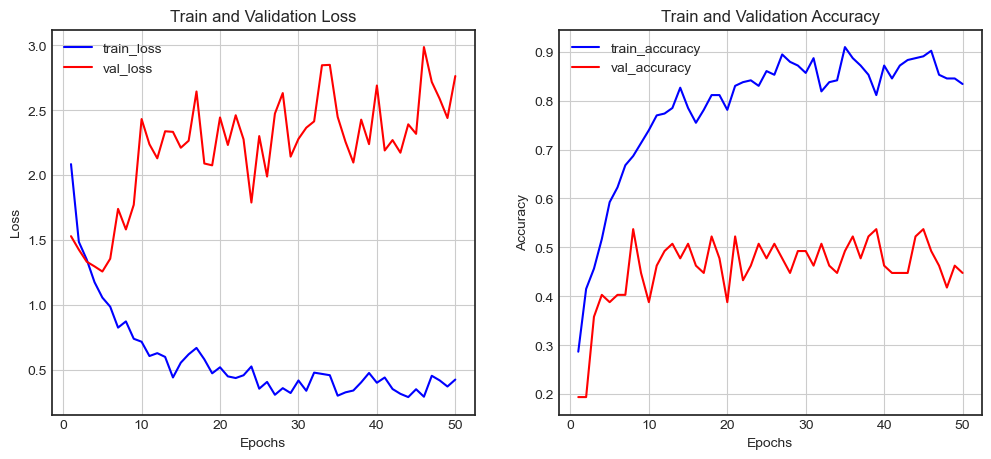

In [85]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()